# On the Diagramatic Diagnosis of Data

## Tools to make your data analysis and machine learning both easier and more reliable

Ian Ozsvald, PyConUK 2018

License: Creative Commons By Attribution

* http://ianozsvald.com
* @ianozsvald

Notes to Ian: `jupyter nbconvert pyconuk2018_slides.ipynb --to slides --post serve`

Add ?print-pdf to print `http://127.0.0.1:8000/<some-title>.slides.html?print-pdf`

* https://github.com/damianavila/RISE/issues/411
* https://github.com/hakimel/reveal.js/issues/1122

In [1]:
import sys
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#if not sys.warnoptions:
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

/home/ian/anaconda3/envs/pyconuk2018/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ian/anaconda3/envs/pyconuk2018/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Ian's background

* Senior data science coach (Channel 4, Hailo, QBE Insurance)
* Author of High Performance Python (O'Reilly)
* Co-founder of PyDataLondon meetup (8,000+ members) and conference (5 years old)
* Past speaker (Random Forests and ML Diagnostics) at PyConUK
* Blog - http://ianozsvald.com

# Have you ever...

* Been asked to complete a data analysis or ML task on new data - sight unseen? Raise hands?
* I hypothesise that there are more engineers in this room than data scientists - show of hands?

# We'll cover

* Google Facets
* Pandas pivot_table and styling
* Pandas Profiling
* Seaborn
* `discover_feature_relationships`
* The proposed "Data Stories" at the end might make you more confident when presenting your own ideas for investigation

# Google Facets

* https://pair-code.github.io/facets/
* Handles strings and numbers from CSVs
* 1d and up to 4d plots (!)

# Facets overview (1D)

![alt text](facets/facets_overview.png "Facets")


# Facets Dive (2D)

![alt text](facets/facets_dive_survived.png "Facets")


# Facets Dive (4D)

![alt text](facets/facets_dive_age_sex_survived.png "Facets")


# Facets

* Non-programmatic (you can't clean or add columns)
* You can upload your own CSV files after you add new features
* Interactivity is nice

In [2]:
titanic = pd.read_csv("titanic_train.csv").set_index('PassengerId')
titanic['Survived'] = titanic.Survived.astype(np.float_)
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#titanic['is_male'] = (titanic.Sex == 'male').astype(np.float_)
#titanic.is_male.value_counts()

# Pandas pivot_table and styling

* Cut numeric columns into labeled bins
* Pivot_table to summarise
* Apply styling to add colours
* See https://github.com/datapythonista/towards_pandas_1/blob/master/Towards%20pandas%201.0.ipynb
  * Via https://twitter.com/datapythonista

In [4]:
titanic['age_'] = titanic.Age.fillna(titanic.Age.median())

titanic['has_family_'] = (titanic.Parch + titanic.SibSp) > 0
titanic.has_family_.value_counts()

False    537
True     354
Name: has_family_, dtype: int64

In [5]:
titanic['age_labeled_'] = pd.cut(titanic['age_'],
                       bins=[titanic.age_.min(), 18, 40, titanic.age_.max()],
                       labels=['Child', 'Young', 'Over_40'])
titanic['age_labeled_'].value_counts()

Young      602
Over_40    150
Child      138
Name: age_labeled_, dtype: int64

In [6]:
titanic[['Survived', 'Pclass', 'age_labeled_', 'Age']].head(10)

,Survived,Pclass,age_labeled_,Age
PassengerId,,,,
1,0.0,3,Young,22.0
2,1.0,1,Young,38.0
3,1.0,3,Young,26.0
4,1.0,1,Young,35.0
5,0.0,3,Young,35.0
6,0.0,3,Young,NaN
7,0.0,1,Over_40,54.0
8,0.0,3,Child,2.0
9,1.0,3,Young,27.0


In [7]:
df_pivot = titanic.pivot_table(values='Survived', columns='Pclass', index='age_labeled_', aggfunc='mean')
df_pivot

Pclass,1,2,3
age_labeled_,,,
Child,0.875000,0.793103,0.344086
Young,0.669355,0.421488,0.232493
Over_40,0.513158,0.382353,0.075000


In [8]:
df_pivot = df_pivot.rename_axis('', axis='columns')
df_pivot = df_pivot.rename('Class {}'.format, axis='columns')
df_pivot.style.format('{:.2%}')

,Class 1,Class 2,Class 3
age_labeled_,,,
Child,87.50%,79.31%,34.41%
Young,66.94%,42.15%,23.25%
Over_40,51.32%,38.24%,7.50%


In [9]:
# https://pandas.pydata.org/pandas-docs/stable/style.html
# NOTE in the PDF you are missing the yellow highlighting on Class 1 (that's an export problem!)
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

df_pivot.style.format('{:.2%}') \
        .apply(highlight_max, axis=1) \
        .set_caption('Survival rates by class and age')

,Class 1,Class 2,Class 3
age_labeled_,,,
Child,87.50%,79.31%,34.41%
Young,66.94%,42.15%,23.25%
Over_40,51.32%,38.24%,7.50%


# Pivot table and styling benefits

* Summarise relationships visually
* Highlight (and give background colours) to call out results
* Push the resulting DataFrame into a Seaborn `heatmap` (not shown) for a `.png` export

In [10]:
# only run this to generate the static output when required
# as pp also messes with the default visual styles
#import pandas_profiling as pp
#profile = pp.ProfileReport(titanic, check_correlation=False)
#profile.to_file(outputfile="./titanic_pp.html") 


# Pandas Profiling

* https://github.com/pandas-profiling/pandas-profiling
* Take a look at the exported html: http://localhost:8000/titanic_pp.html
* Add the exported html artefact to your source control


```
# report in the Notebook
pp.ProfileReport(titanic)

# report to an html file (i.e. generate an artefact)
profile = pp.ProfileReport(titanic)
profile.to_file(outputfile="./titanic_pp.html") 
```

# Seaborn

* Additional statistical plots on top of matplotlib and Pandas' own
* See https://www.kaggle.com/ravaliraj/titanic-data-visualization-and-ml


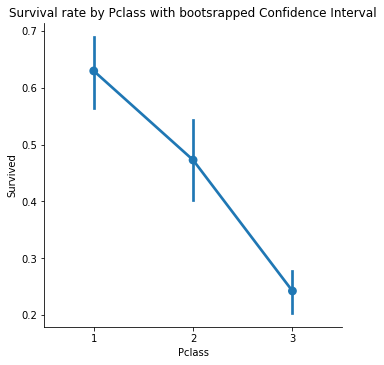

In [11]:
fg = sns.catplot('Pclass', 'Survived', data=titanic, kind='point')
fg.ax.set_title("Survival rate by Pclass with bootsrapped Confidence Interval");

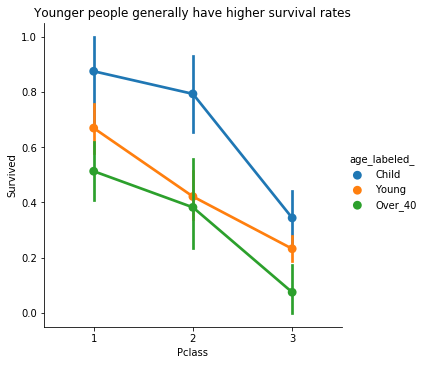

In [12]:
fg = sns.catplot('Pclass', 'Survived', data=titanic, hue='age_labeled_', kind='point');
fg.ax.set_title("Younger people generally have higher survival rates");

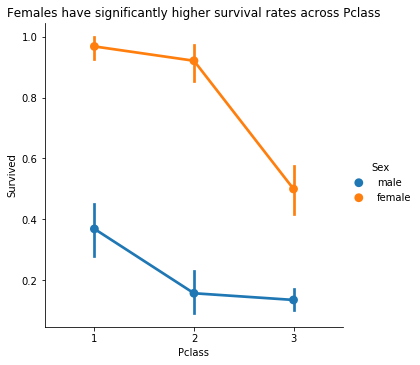

In [13]:
fg = sns.catplot('Pclass', 'Survived', data=titanic, hue='Sex', kind='point');
fg.ax.set_title("Females have significantly higher survival rates across Pclass");

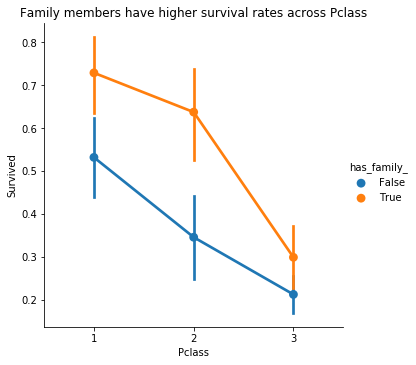

In [14]:
fg = sns.catplot('Pclass', 'Survived', data=titanic, hue='has_family_', kind="point");
fg.ax.set_title("Family members have higher survival rates across Pclass");

# Seaborn benefits

* Visualise pivot-table results
* Clearly show 3D relationships
* Work using the DataFrame that you're manipulating (with new features and cleaner data)

# Seaborn on the Boston dataset

* See also aplunket.com/data-exploration-boston-data-part-2/
* Smarter 2D scatter, rug and hex plots

In [15]:
from sklearn.datasets import load_boston
boston_data = load_boston()
boston = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
boston['MEDV'] = boston_data.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


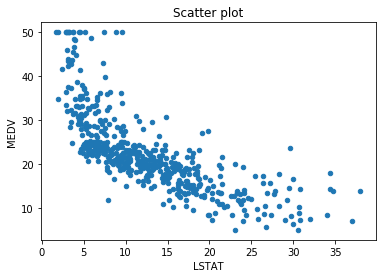

In [16]:
ax = boston[['LSTAT', 'MEDV']].plot(kind="scatter", x="LSTAT", y="MEDV");
ax.set_title("Scatter plot");

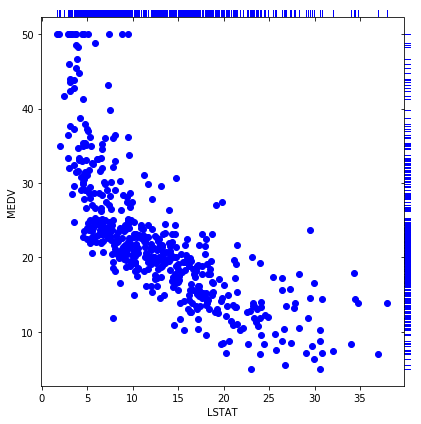

In [17]:
grid = sns.JointGrid(x='LSTAT', y='MEDV', data=boston, space=0, height=6, ratio=50)
grid.plot_joint(plt.scatter, color="b")
grid.plot_marginals(sns.rugplot, color="b", height=4);

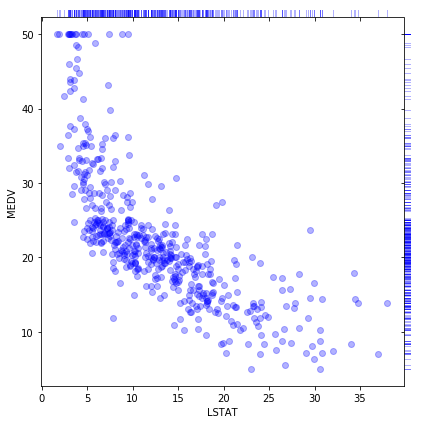

In [18]:
grid = sns.JointGrid(x='LSTAT', y='MEDV', data=boston, space=0, height=6, ratio=50)
grid.plot_joint(plt.scatter, color="b", alpha=0.3)
grid.plot_marginals(sns.rugplot, color="b", height=4, alpha=.3);

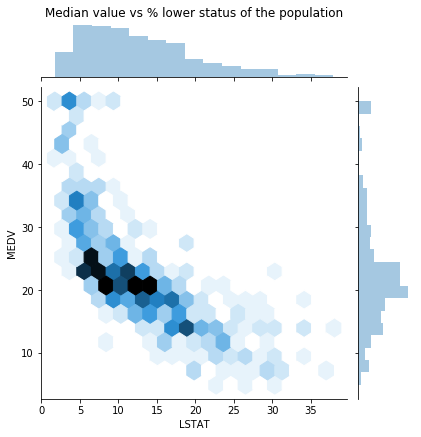

In [19]:
jg = sns.jointplot(boston.LSTAT, boston.MEDV, kind='hex')
jg.ax_marg_x.set_title("Median value vs % lower status of the population");

# Pair plots

* Show scatter and kernel density (kde) plots for feature pairs
* See http://gael-varoquaux.info/interpreting_ml_tuto/content/01_how_well/02_cross_validation.html

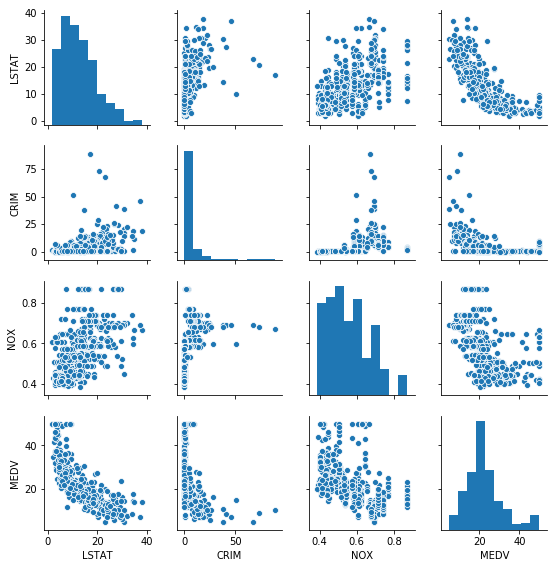

In [20]:
boston_smaller = boston[['LSTAT', 'CRIM', 'NOX', 'MEDV']]
sns.pairplot(boston_smaller, height=2);

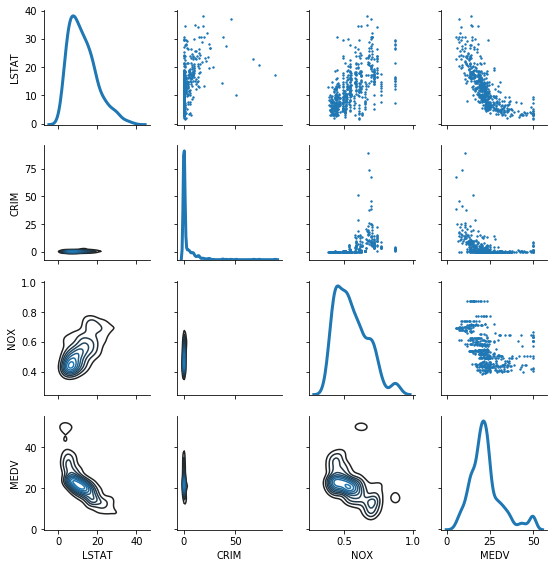

In [21]:
g = sns.PairGrid(boston_smaller, diag_sharey=False, height=2)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter, s=2)
g.map_diag(sns.kdeplot, lw=3);

In [22]:
%load_ext autoreload
%autoreload 2
from discover_feature_relationships import discover

/home/ian/anaconda3/envs/pyconuk2018/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# `discover_feature_relationships`

* Which features predict other features?
  * What relationships exist between all pairs of single columns?
  * Could we augment our data if we know the underlying relationships?
  * Can we identify poorly-specified relationships?
* Go beyond Pearson and Spearman correlations (but we can do these too)
* https://github.com/ianozsvald/discover_feature_relationships/

In [23]:
#cols = ['CRIM', 'RAD', 'MEDV'] # light version during dev


In [24]:
cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
classifier_overrides = set() # classify these columns rather than regress (in Boston everything can be regressed)
%time df_results = discover.discover(boston[cols].sample(frac=1), classifier_overrides, method="spearman")

CPU times: user 868 ms, sys: 0 ns, total: 868 ms
Wall time: 867 ms


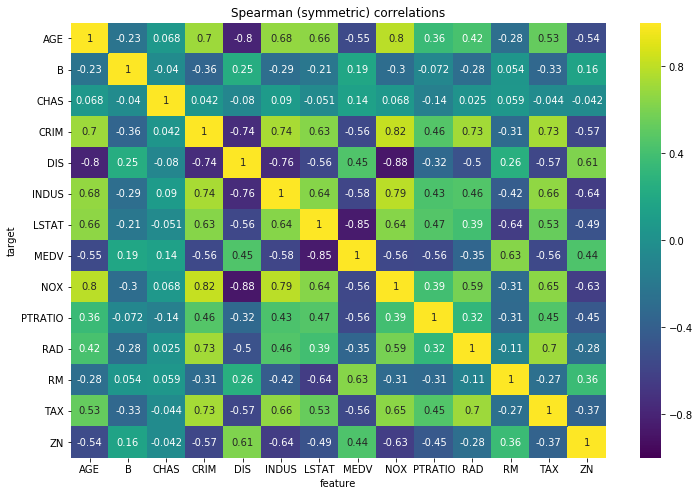

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_results.pivot(index='target', columns='feature', values='score').fillna(1),
            annot=True, center=0, ax=ax, vmin=-1, vmax=1, cmap="viridis");
ax.set_title("Spearman (symmetric) correlations");

In [26]:
%time df_results = discover.discover(boston[cols].sample(frac=1), classifier_overrides)

CPU times: user 15.2 s, sys: 5.41 s, total: 20.6 s
Wall time: 1min 21s


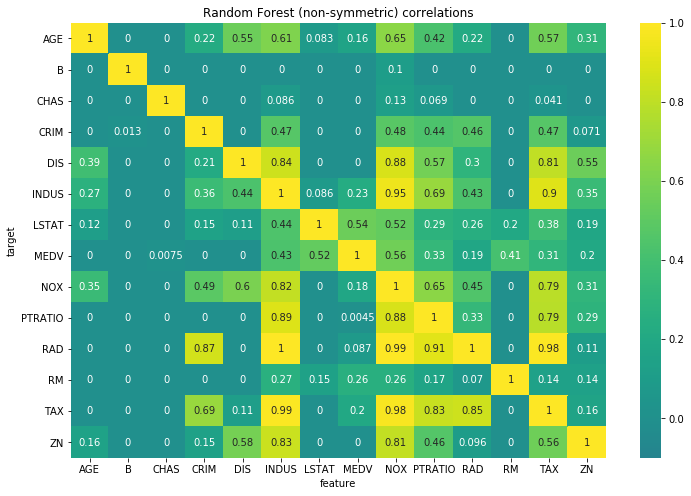

In [27]:
# CRIM predicts RAD but RAD poorly predicts CRIM - why?
# MEDV (target) is predicted by NOX, NOX is predicted by INDUS - could we get anything further by improving this?
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_results.pivot(index='target', columns='feature', values='score').clip_lower(0).fillna(1),
            annot=True, center=0, ax=ax, vmin=-0.1, vmax=1, cmap="viridis");
ax.set_title("Random Forest (non-symmetric) correlations");

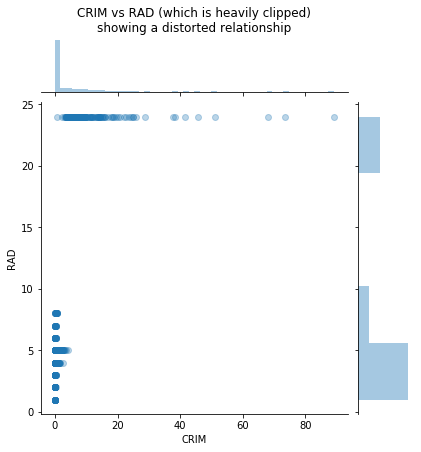

In [28]:
# RAD figures are clipped which distorts the relationship with CRIM!
# we've identified some dodgy data - maybe we could look for better data sources?
jg = sns.jointplot(boston.CRIM, boston.RAD, alpha=0.3)
jg.ax_marg_x.set_title("CRIM vs RAD (which is heavily clipped)\nshowing a distorted relationship");

# Data Stories

* Proposed by Bertil: https://medium.com/@bertil_hatt/what-does-bad-data-look-like-91dc2a7bcb7a
* A short report describing the data and proposing things we could do with it
* Use Facets and Pandas Profiling to describe the main features
* Use `discover_feature_relationships` and `PairGrid` to describe interesting relationships 
* Note if there are parts of the data we don't trust (time ranges? sets of columns?)
  * Bonus - take a look at the `missingno` missing number library
* Propose experiments that we might run on this data which generate a benefit
* This presentation is a _Jupyter Notebook_ in _presentation mode_ (i.e. a source controlled code artefact)

# Conclusion

* We've looked at a set of tools that enable Python engineers and data scientists to review their data
* Looking beyond 2D correlations we might start to dig further into our data's relationships
* A Data Story will help colleagues to understand what can be achieved with this data
* See my `Data Science Delivered` repo on github.com/ianozsvald
* Did you learn something? I love receiving postcards! Please email me and I'll send you my address
* Talk to me about team coaching
* Please try my tool - I'd love feedback: https://github.com/ianozsvald/discover_feature_relationships
* Please come to a PyData event and please thank your fellow volunteers here

Ian Ozsvald (http://ianozsvald.com , http://twitter.com/ianozsvald)